<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/experiments/fair-regression/notebooks/03 Tune Learning Rate for LSP" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import pandas as pd

In [ ]:
# import importlib

## Import our own modules

In [ ]:
# !rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 542 (delta 199), reused 180 (delta 105), pack-reused 190
Receiving objects: 100% (542/542), 10.99 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (295/295), done.


(Using Colab)

In [ ]:
import sys

In [ ]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [ ]:
import lib
# importlib.reload(lib)

In [ ]:
from lib.utils_data import Regression_Data
from lib.lsp.basis_generator import phi_lam_legendre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.fair_reg_solver_sgd import fair_train_sgd, fair_test_sgd

#Learning the Solution Path Through SGD
Now, let us run SGD over random $\tilde λ$'s with a linear basis $\Phi(\tilde \lambda)$ of our choice. We want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function is $\min_\beta h(\Phi(\tilde\lambda)\beta, \tilde\lambda) = (1-\tilde\lambda) BCE(X_\text{pass}\Phi(\tilde\lambda)\beta,\ y_\text{pass}) + \tilde\lambda BCE(X_\text{fail}\Phi(\tilde\lambda)\beta,\ y_\text{fail})$. For each batch of training data set, we randomize $\tilde\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

In [ ]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [ ]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [ ]:
full_data = Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=20, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

## Our Model

We use Legendre polynomials with degree $\leq n$ as the basis vectors for $\Phi(\lambda)$.

In [ ]:
phi_lam = phi_lam_legendre

In [ ]:
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

## Tuning the learning rate for our model

In [ ]:
lr_list = 0.5 ** np.arange(-2, 11)
alpha_list = 0.5 ** np.arange(-4, 9)
epochs = 500
lam = 0.5
input_dim = X.shape[1]
criterion = torch.nn.BCELoss()

In [ ]:
X_tune = X[:200, :]
y_tune = y[:200]

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = Regression_Data(X_tune, y_tune)
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=20, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

Though the plots suggests higher learning rates, we choose learning rate = $0.5$ to prevent overshoot.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 3

losses = []
for lr in lr_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

learning rate: 4.0	 loss: 0.0033615687862038612
learning rate: 2.0	 loss: 0.025367872789502144
learning rate: 1.0	 loss: 0.022284287959337234
learning rate: 0.5	 loss: 0.02974347025156021
learning rate: 0.25	 loss: 0.04989827051758766
learning rate: 0.125	 loss: 0.07438865303993225
learning rate: 0.0625	 loss: 0.10816153883934021
learning rate: 0.03125	 loss: 0.1715240776538849
learning rate: 0.015625	 loss: 0.2499810755252838
learning rate: 0.0078125	 loss: 0.3244830071926117
learning rate: 0.00390625	 loss: 0.4217647910118103
learning rate: 0.001953125	 loss: 0.4775502383708954
learning rate: 0.0009765625	 loss: 0.5224681496620178


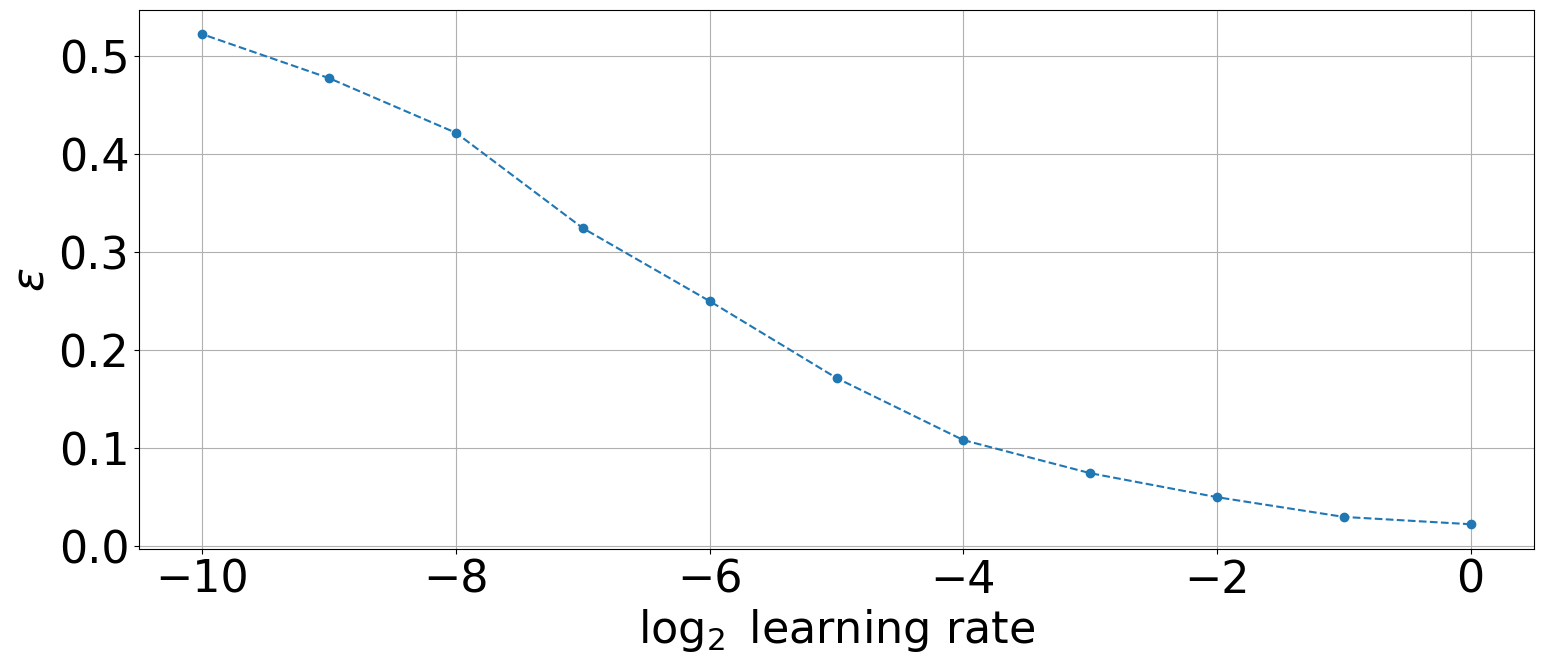

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[2:]), losses[2:], '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for lr in lr_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

learning rate: 4.0	 loss: 7.797882080078125
learning rate: 2.0	 loss: 2.9623489379882812
learning rate: 1.0	 loss: 0.03466842323541641
learning rate: 0.5	 loss: 0.04448813572525978
learning rate: 0.25	 loss: 0.05212162435054779
learning rate: 0.125	 loss: 0.07549691200256348
learning rate: 0.0625	 loss: 0.11803260445594788
learning rate: 0.03125	 loss: 0.16876006126403809
learning rate: 0.015625	 loss: 0.24584326148033142
learning rate: 0.0078125	 loss: 0.32264864444732666
learning rate: 0.00390625	 loss: 0.41238489747047424
learning rate: 0.001953125	 loss: 0.47386419773101807
learning rate: 0.0009765625	 loss: 0.5244783759117126


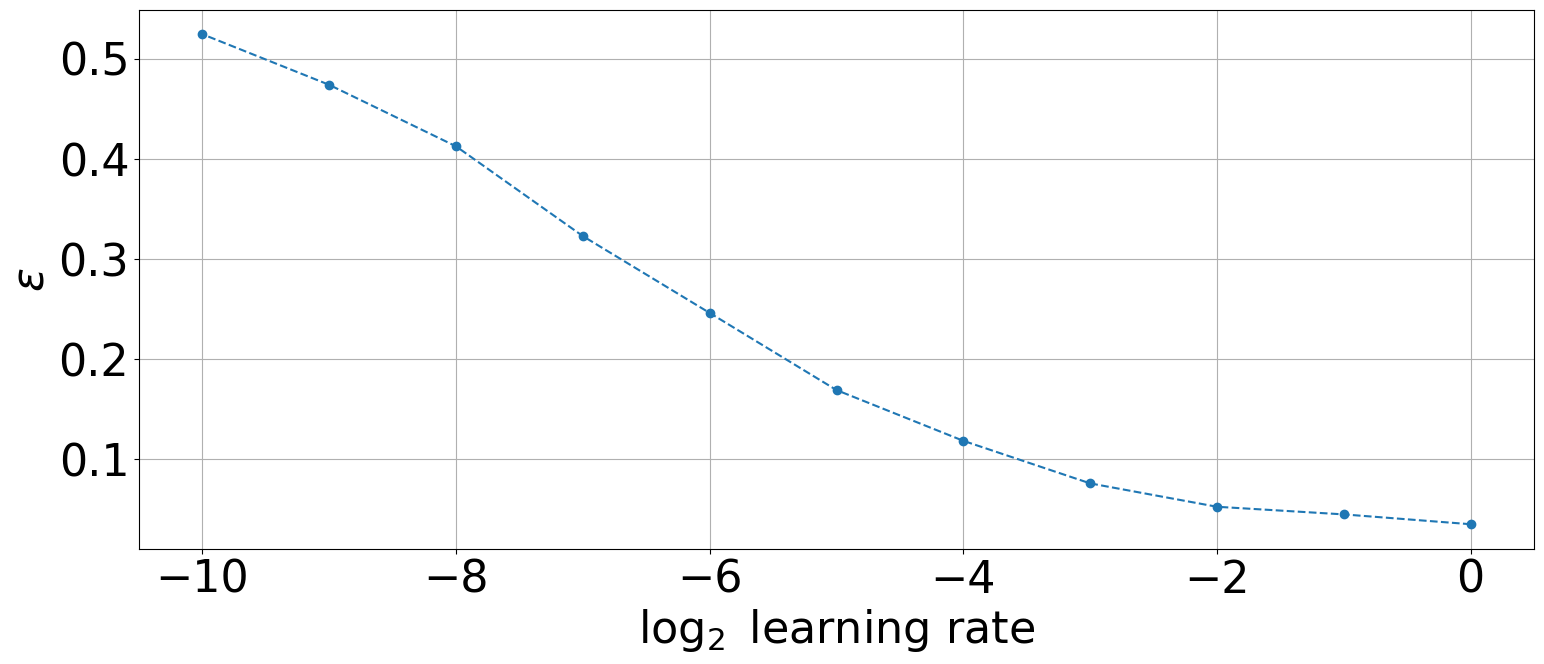

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[2:]), plosses[2:], '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 7

losses = []
for lr in lr_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

learning rate: 4.0	 loss: 8.319311141967773
learning rate: 2.0	 loss: 25.029462814331055
learning rate: 1.0	 loss: 0.049578167498111725
learning rate: 0.5	 loss: 1.025393009185791
learning rate: 0.25	 loss: 0.05582302063703537
learning rate: 0.125	 loss: 0.07573901116847992
learning rate: 0.0625	 loss: 0.11664033681154251
learning rate: 0.03125	 loss: 0.17151284217834473
learning rate: 0.015625	 loss: 0.2674548029899597
learning rate: 0.0078125	 loss: 0.33203816413879395
learning rate: 0.00390625	 loss: 0.4206441044807434
learning rate: 0.001953125	 loss: 0.4744987487792969
learning rate: 0.0009765625	 loss: 0.5274477005004883


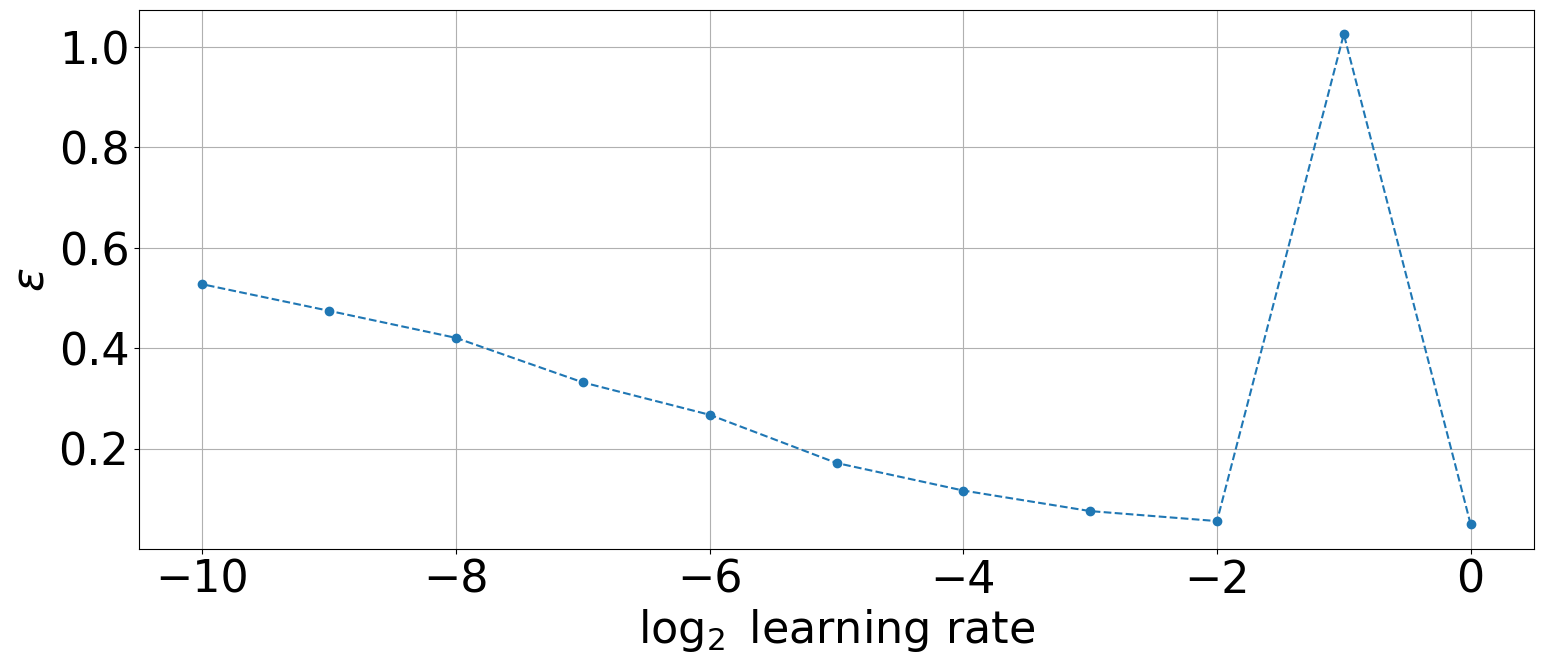

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[2:]), losses[2:], '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 3

losses = []
for alpha in alpha_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = min([0.1, alpha/(t+1)])
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

alpha: 16.0	 loss: 0.05747831612825394
alpha: 8.0	 loss: 0.07206960022449493
alpha: 4.0	 loss: 0.08426413685083389
alpha: 2.0	 loss: 0.12970930337905884
alpha: 1.0	 loss: 0.15969282388687134
alpha: 0.5	 loss: 0.2522071897983551
alpha: 0.25	 loss: 0.34039852023124695
alpha: 0.125	 loss: 0.4075910449028015
alpha: 0.0625	 loss: 0.5080386400222778
alpha: 0.03125	 loss: 0.5551321506500244
alpha: 0.015625	 loss: 0.579634964466095
alpha: 0.0078125	 loss: 0.5891046524047852
alpha: 0.00390625	 loss: 0.619204580783844


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 3.



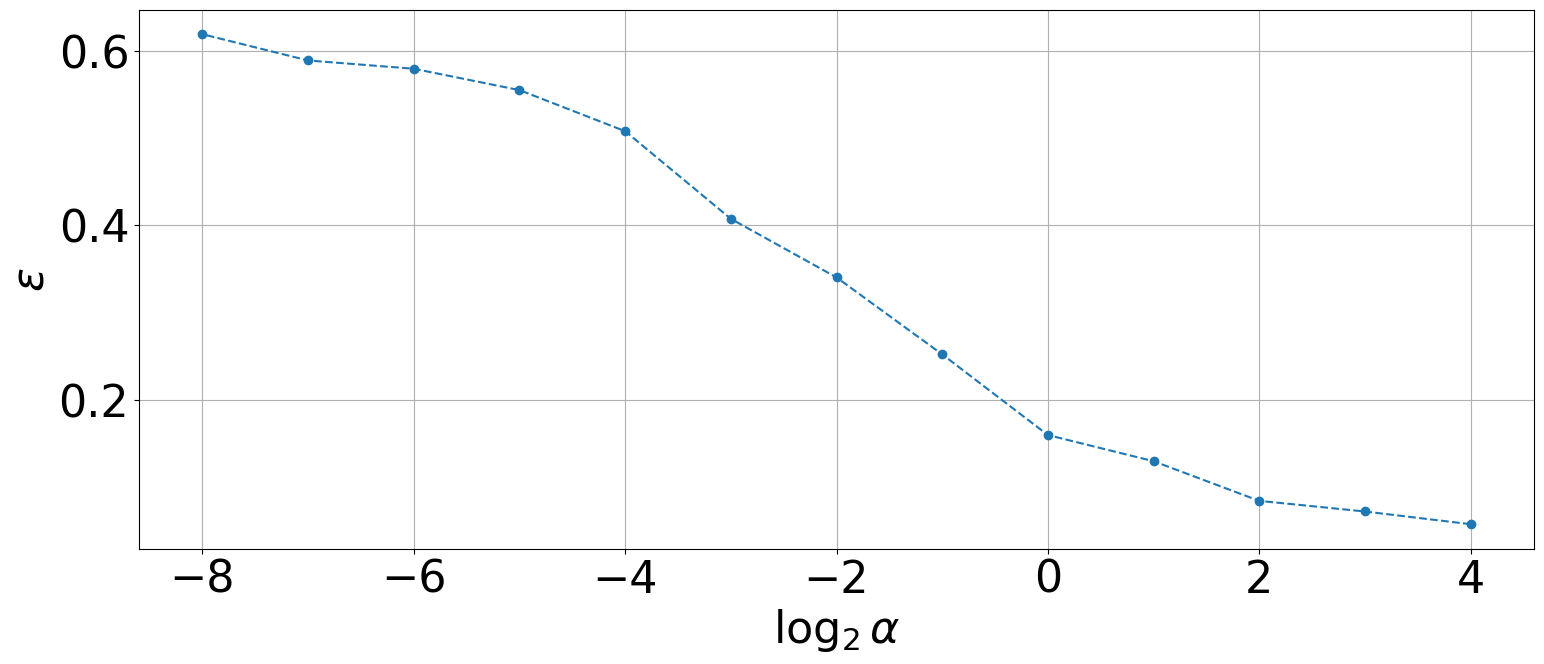

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(alpha_list), losses, '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 4

losses = []
for alpha in alpha_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = min([0.1, alpha/(t+1)])
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

alpha: 16.0	 loss: 0.05329572409391403
alpha: 8.0	 loss: 0.06090482324361801
alpha: 4.0	 loss: 0.08741861581802368
alpha: 2.0	 loss: 0.11416233330965042
alpha: 1.0	 loss: 0.15697407722473145
alpha: 0.5	 loss: 0.2801080048084259
alpha: 0.25	 loss: 0.30374470353126526
alpha: 0.125	 loss: 0.5230830907821655
alpha: 0.0625	 loss: 0.5155892968177795
alpha: 0.03125	 loss: 0.523331880569458
alpha: 0.015625	 loss: 0.5756393671035767
alpha: 0.0078125	 loss: 0.596881628036499
alpha: 0.00390625	 loss: 0.6556395888328552


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 4.



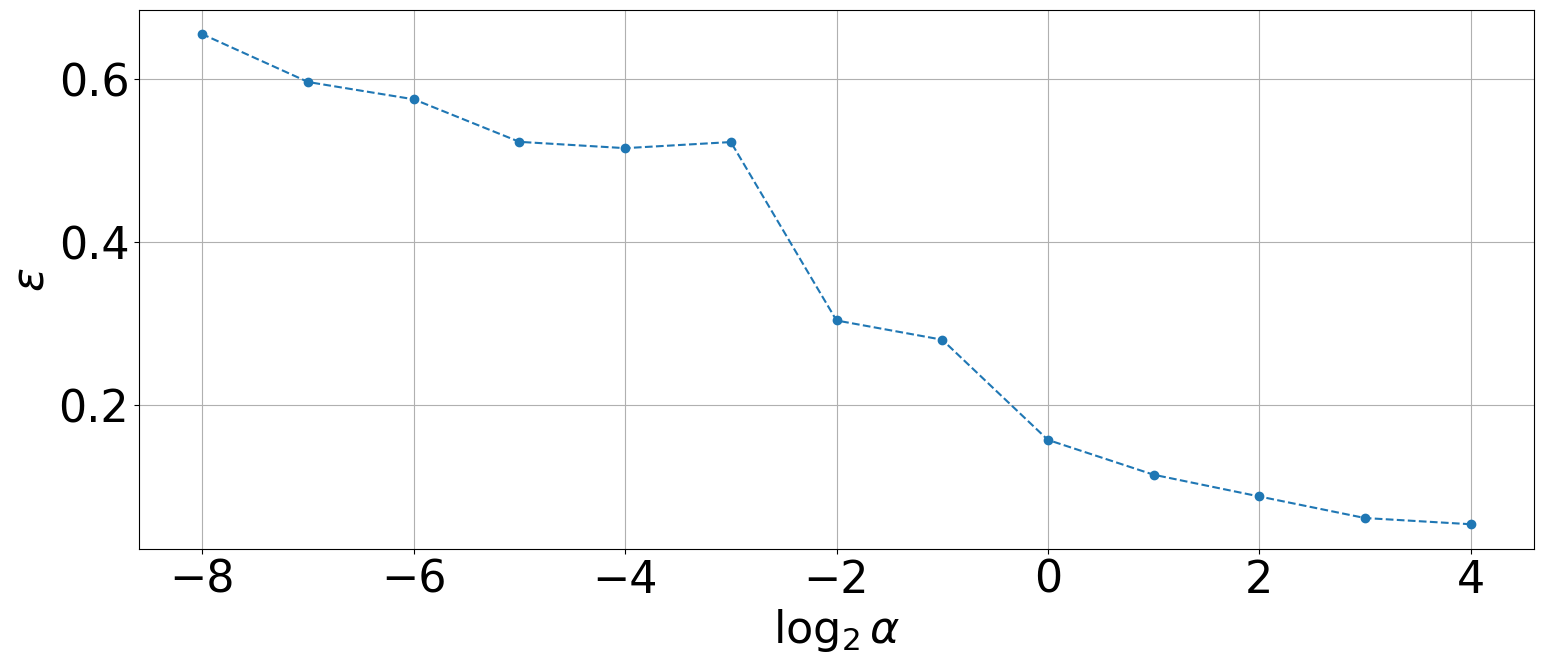

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(alpha_list), losses, '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for alpha in alpha_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = min([0.1, alpha/(t+1)])
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

losses = np.array(losses)

alpha: 16.0	 loss: 0.04866383224725723
alpha: 8.0	 loss: 0.0674123615026474
alpha: 4.0	 loss: 0.08574336767196655
alpha: 2.0	 loss: 0.1438950151205063
alpha: 1.0	 loss: 0.1514730155467987
alpha: 0.5	 loss: 0.21774058043956757
alpha: 0.25	 loss: 0.31940746307373047
alpha: 0.125	 loss: 0.5008350014686584
alpha: 0.0625	 loss: 0.5415816307067871
alpha: 0.03125	 loss: 0.5217517018318176
alpha: 0.015625	 loss: 0.5822649002075195
alpha: 0.0078125	 loss: 0.5948375463485718


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 5.



In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(alpha_list), losses, '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)